# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
%matplotlib inline

In [6]:
#os.chdir("..")
#current_working_dir = os.getcwd()
#print(current_working_dir)
#data = pd.read_csv(r'output/measures/measure_STARPU_antibiotics.csv')
#data

In [7]:
#data = pd.read_csv("C:/Users/m84300af/OneDrive - The University of Manchester/Documents/GitHub/amr-uom-brit/output/measures/input_2019-01-01.csv.gz")
#data

In [10]:
os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)
data = pd.read_csv(r'output/measures/input_2020-06-01.csv.gz', compression='gzip')
data

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,covrx1_dat,covrx2_dat,died_date,uti_date_1,...,lrti_counts,uti_ab_count_1,uti_ab_count_2,uti_ab_count_3,uti_ab_count_4,lrti_ab_count_1,lrti_ab_count_2,lrti_ab_count_3,lrti_ab_count_4,patient_id
0,2021-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,8130
1,2021-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,0,0,2,0,0,0,0,5723
2,2020-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,4,0,0,0,0,1043
3,2021-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,5,0,0,0,0,0,0,5,186
4,2021-02,NaN,NaN,2018-02,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,6,0,0,1021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2020-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,3,0,0,0,7778
996,2019-10,NaN,NaN,2018-02,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,5,6,0,3871
997,2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,3067
998,2020-08,NaN,2021-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,5,0,0,0,3047


In [6]:
#read csv.gz files and concatenate them
#path2 = os.getcwd()+'\output\measures'
##path1 = r'C:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\output\measures'
##all_files = glob.glob(os.path.join(path1, "*.csv.gz"))
##print(path1)

##data = pd.concat((pd.read_csv(f) for f in all_files))
##data

In [4]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'sgss_positive', 'covrx1_dat', 'covrx2_dat',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'uti_ab_count_1',
       'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4', 'lrti_ab_count_1',
       'lrti_ab_count_2', 'lrti_ab_count_3', 'lrti_ab_count_4', 'patient_id'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 45 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   bmi_date_measured                         950 non-null    object 
 1   smoking_status_date                       100 non-null    object 
 2   most_recent_unclear_smoking_cat_date      100 non-null    object 
 3   flu_vaccine_med                           100 non-null    object 
 4   flu_vaccine_clinical                      100 non-null    object 
 5   sgss_positive                             100 non-null    object 
 6   covrx1_dat                                0 non-null      float64
 7   covrx2_dat                                0 non-null      float64
 8   died_date                                 100 non-null    object 
 9   uti_date_1                                100 non-null    object 
 10  uti_date_2                           

In [6]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,covrx1_dat,covrx2_dat,died_date,uti_date_1,...,lrti_counts,uti_ab_count_1,uti_ab_count_2,uti_ab_count_3,uti_ab_count_4,lrti_ab_count_1,lrti_ab_count_2,lrti_ab_count_3,lrti_ab_count_4,patient_id
count,950,100,100,100,100,100,0.0,0.0,100,100,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
unique,34,34,32,12,6,93,NaN,NaN,82,95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-07,2019-05,2019-05,2018-11,2018-12,2020-06-04,NaN,NaN,2021-09-04,2020-12-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,38,7,6,12,19,2,NaN,NaN,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.926000,0.907000,0.901000,0.911000,0.907000,0.871000,0.900000,0.90200,0.883000,4731.692000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.907397,1.868647,1.855436,1.877926,1.872393,1.799888,1.863189,1.85306,1.823907,2866.935574
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2242.750000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4554.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,7112.500000


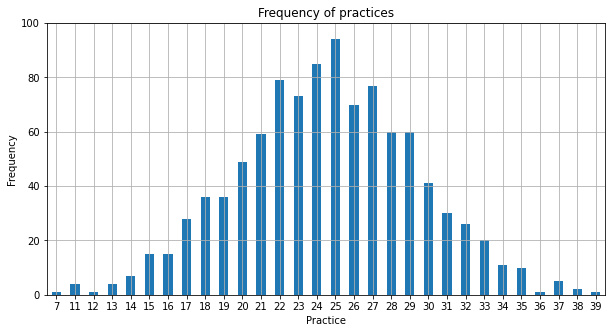

In [7]:
#data['practice'].value_counts().sort_index()

data['practice'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), rot=0)
plt.xlabel('Practice')
plt.ylabel('Frequency')
plt.title('Frequency of practices')
#plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid()
plt.savefig(r'output/hospitalisation_risk/practices.png', edgecolor='none')
plt.show()

F    516
M    484
Name: sex, dtype: int64


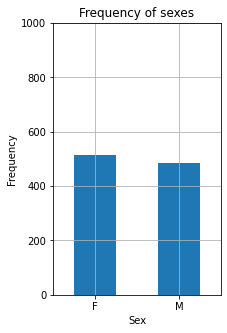

In [8]:
#data['sex'].value_counts().sort_index()

data['sex'].value_counts().sort_index().plot(kind='bar', figsize=(3, 5), rot=0)
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Frequency of sexes')
#plt.xlim(0, 100)
plt.ylim(0, 1000)
plt.grid()
print(data['sex'].value_counts().sort_index())
plt.savefig(r'output/hospitalisation_risk/sexes.png', edgecolor='none')
plt.show()

0-4      112
15-24    116
25-34    112
35-44    117
45-54     97
5-14     115
55-64    136
65-74    100
75+       95
Name: age_cat, dtype: int64


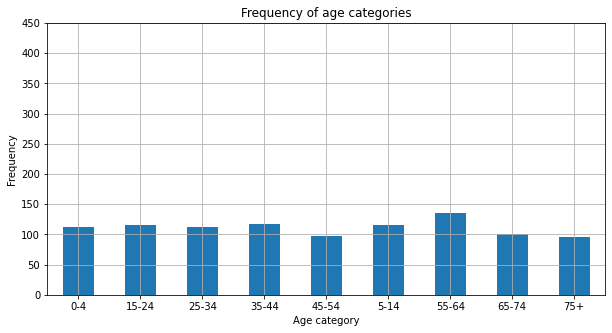

In [9]:
#data['age_cat'].value_counts().sort_index()

data['age_cat'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), rot=0)
plt.xlabel('Age category')
plt.ylabel('Frequency')
plt.title('Frequency of age categories')
#plt.xlim(0, 100)
plt.ylim(0, 450)
plt.grid()
print(data['age_cat'].value_counts().sort_index())
plt.savefig(r'output/hospitalisation_risk/age_categories.png', edgecolor='none')
plt.show()

C:\Users\m84300af\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


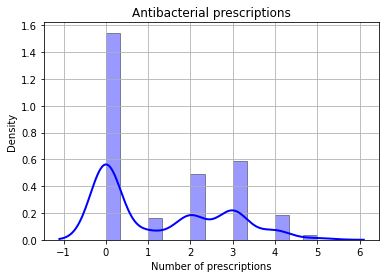

In [10]:
sns.distplot(data['antibacterial_prescriptions'], hist=True, kde=True, 
             bins=15, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

plt.xlabel('Number of prescriptions')
#plt.ylabel('Frequency')
plt.title('Antibacterial prescriptions')
#plt.xlim(0, 100)
#plt.ylim(0, 1100)
plt.grid(True)
plt.savefig(r'output/hospitalisation_risk/antibacterial_prescirption.png', edgecolor='none')
plt.show()

In [11]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'sgss_positive', 'covrx1_dat', 'covrx2_dat',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'uti_ab_count_1',
       'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4', 'lrti_ab_count_1',
       'lrti_ab_count_2', 'lrti_ab_count_3', 'lrti_ab_count_4', 'patient_id'],
      dtype='object')

In [12]:
data['bmi']

0      41.660379
1      33.295191
2      30.874854
3      29.506215
4      16.816129
         ...    
995    47.852037
996    34.673937
997    35.149056
998    29.731277
999    54.060677
Name: bmi, Length: 1000, dtype: float64